In this notebook I created a deep convolutional neural network using functional API of keras module. My submission to Digit 

Recognizer got a score of 99.025% which is improved as compared to my previous submission using deep neural network and 

sequential api. Lets see how can we create a convolutional layers which is building block of Computer Vision.

PROBLEM STATEMENT:

We have a training set consisting of gray scale images of pixels size (28,28,1).There are hand written images in the training 

data and we have to identify its label using our machine learning model. 

In [1]:
# Importing required libraries
import numpy as np 
import pandas as pd #For loading csv files
from tensorflow import keras  # Keras module for creating our CNN
from tensorflow.keras import layers #layers to add in our neural net
import tensorflow as tf
import matplotlib.pyplot as plt #Plotting library

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
y = train['label']
train = train.drop(['label'],axis =1) # Dropping the label of training data so as to use this to create mapping
print(train)

       pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0           0       0       0       0       0       0       0       0       0   
1           0       0       0       0       0       0       0       0       0   
2           0       0       0       0       0       0       0       0       0   
3           0       0       0       0       0       0       0       0       0   
4           0       0       0       0       0       0       0       0       0   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
41995       0       0       0       0       0       0       0       0       0   
41996       0       0       0       0       0       0       0       0       0   
41997       0       0       0       0       0       0       0       0       0   
41998       0       0       0       0       0       0       0       0       0   
41999       0       0       0       0       0       0       0       0       0   

       pixel9  ...  pixel77

In [6]:
X = tf.convert_to_tensor(train)

s = tf.shape(X)

y = tf.convert_to_tensor(y)
Xtest =tf.convert_to_tensor(test)
w = tf.shape(Xtest)
print(s)
print(w)

tf.Tensor([42000   784], shape=(2,), dtype=int32)
tf.Tensor([28000   784], shape=(2,), dtype=int32)


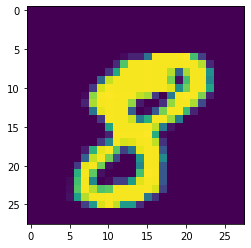

In [17]:
plt.imshow(next(X).numpy().astype("uint8"))#Visualize images in train set

In [7]:
X = tf.reshape(X,(s[0],28,28,1))
Xtest = tf.reshape(Xtest,(w[0],28,28,1))

In [8]:
unique, counts = np.unique(np.array(y), return_counts=True)#understand distribution of y_train so as to choose metric for classification
#As the distribution of y_train in this dataset is somewhat uniform we can use accuarcy as evaluation metric 
print (np.asarray((unique, counts)).T)

[[   0 4132]
 [   1 4684]
 [   2 4177]
 [   3 4351]
 [   4 4072]
 [   5 3795]
 [   6 4137]
 [   7 4401]
 [   8 4063]
 [   9 4188]]


Lets do some data preprocessing to our data

In [9]:
X = tf.cast(X,float)
X = X/255.0

Xtest = tf.cast(Xtest,float)
Xtest = Xtest/255.0


In [11]:
initializer1 = tf.keras.initializers.GlorotNormal()#Glorot Normal initializer/Xavier initialization works better for sigmoid layers
initializer2 = tf.keras.initializers.HeNormal()#He initalizer works better for Relu layers

def convolutional_model(input_shape):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> DENSE
    
    Arguments:
    input_img -- input dataset, of shape (input_shape)

    Returns:
    model -- TF Keras model (object containing the information for the entire training process) 
    """
    
    input_img = tf.keras.Input(shape=input_shape)
    # Adding Conv2D layers to our neural network
    
    Z1 = tf.keras.layers.Conv2D(8,4,strides =(1,1),padding = 'same', kernel_initializer =initializer2 )(input_img)
    
    
    # Performing batch normalization so as to address the problem of covariance shift 
    
    b1 = tf.keras.layers.BatchNormalization(3)(Z1)
    
    # Applying relu activation
    A1 =tf.keras.layers.ReLU()(b1)
    
    # Finally adding maxpool layer so as to bring stability to the model using pool size 2 and stride 2
    
    P1 = tf.keras.layers.MaxPool2D(pool_size =(2,2),strides =2, padding = 'same')(A1)

    Z2 = tf.keras.layers.Conv2D(16,2,strides = (1,1),padding ='same',kernel_initializer =initializer2)(P1)
    
    b2 = tf.keras.layers.BatchNormalization(3)(Z2)
    
    A2 = tf.keras.layers.ReLU()(b2)
   
    P2 = tf.keras.layers.MaxPool2D(pool_size = (4,4),strides =1, padding = 'same')(A2)
    
    
    Z3 = tf.keras.layers.Conv2D(24,4,strides =(1,1),padding = 'same', kernel_initializer =initializer2 )(P2)
    
    b3 = tf.keras.layers.BatchNormalization(3)(Z3)
    
    A3 =tf.keras.layers.ReLU()(b3)
    

    F = tf.keras.layers.Flatten()(A3)
    
    #print(F.shape)
    outputs = tf.keras.layers.Dense(10,activation ="softmax",kernel_initializer =initializer1)(F)
    
    model = tf.keras.Model(inputs=input_img, outputs=outputs)
    
    return model

In [12]:
#Using learning rate decay for our optimizer
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-2,decay_steps=1000,decay_rate=0.8)

In [14]:
conv_model = convolutional_model((28,28,1))
conv_model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
# As our labels are not one hot encoded we can use sparse categorical cross entropy as loss function, if our labels are one hot
#encoded then we can use categorical crossentropy as loss function
conv_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 8)         136       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 8)        32        
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 28, 28, 8)         0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 16)        528   

In [15]:
history = conv_model.fit(X,y, epochs=70,validation_split = 0.1,batch_size = 128,verbose=1)
# Fitting our model to training data and use a part of it for cross validation and train using over 70 epochs

Epoch 1/70
296/296 [==============================] - 17s 56ms/step - loss: 0.6061 - accuracy: 0.9183 - val_loss: 0.1678 - val_accuracy: 0.9510
Epoch 2/70
296/296 [==============================] - 16s 54ms/step - loss: 0.0677 - accuracy: 0.9789 - val_loss: 0.0630 - val_accuracy: 0.9790
Epoch 3/70
296/296 [==============================] - 16s 55ms/step - loss: 0.0483 - accuracy: 0.9849 - val_loss: 0.0858 - val_accuracy: 0.9743
Epoch 4/70
296/296 [==============================] - 17s 57ms/step - loss: 0.0368 - accuracy: 0.9891 - val_loss: 0.0516 - val_accuracy: 0.9855
Epoch 5/70
296/296 [==============================] - 16s 55ms/step - loss: 0.0305 - accuracy: 0.9905 - val_loss: 0.0647 - val_accuracy: 0.9805
Epoch 6/70
296/296 [==============================] - 16s 53ms/step - loss: 0.0273 - accuracy: 0.9913 - val_loss: 0.0507 - val_accuracy: 0.9857
Epoch 7/70
296/296 [==============================] - 16s 56ms/step - loss: 0.0244 - accuracy: 0.9920 - val_loss: 0.0497 - val_accuracy:

Epoch 57/70
296/296 [==============================] - 10s 35ms/step - loss: 5.8198e-06 - accuracy: 1.0000 - val_loss: 0.0506 - val_accuracy: 0.9919
Epoch 58/70
296/296 [==============================] - 10s 34ms/step - loss: 5.0719e-06 - accuracy: 1.0000 - val_loss: 0.0503 - val_accuracy: 0.9919
Epoch 59/70
296/296 [==============================] - 10s 34ms/step - loss: 4.4134e-06 - accuracy: 1.0000 - val_loss: 0.0501 - val_accuracy: 0.9921
Epoch 60/70
296/296 [==============================] - 10s 34ms/step - loss: 4.2838e-06 - accuracy: 1.0000 - val_loss: 0.0500 - val_accuracy: 0.9921
Epoch 61/70
296/296 [==============================] - 10s 34ms/step - loss: 3.9808e-06 - accuracy: 1.0000 - val_loss: 0.0511 - val_accuracy: 0.9921
Epoch 62/70
296/296 [==============================] - 10s 33ms/step - loss: 3.3904e-06 - accuracy: 1.0000 - val_loss: 0.0511 - val_accuracy: 0.9919
Epoch 63/70
296/296 [==============================] - 10s 34ms/step - loss: 3.4299e-06 - accuracy: 1.0000

In [16]:
y_pred = conv_model.predict(Xtest)
y_pred = np.argmax(y_pred, axis=1)

In [ ]:
#Now I have submitted my predictions and got a score of 99.025% accuracy